# Подготавливаем данные

Имипортируем необходимые библиотки

In [1]:
import numpy as np
import pandas as pd
import scipy

from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic
from statsmodels.stats.proportion import proportion_confint

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Подключаюсь к гугл-диску с данными

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Course"

ModuleNotFoundError: No module named 'google'

Считываем данные, отображаем точечные оценки

In [4]:
df = pd.read_csv('data.csv', sep=',')
df.shape

(10000, 7)

In [5]:
df.sample(5)

,id,required_amt,installment_flg,monthly_income_amt,age,has_high_education_flg,approved_flg
9822,9823,17091.0,1,25090,22,1,0
3467,3468,8815.0,1,40000,47,0,0
3564,3565,30000.0,0,45000,47,1,1
7992,7993,42454.0,1,24000,49,1,1
8019,8020,35673.0,0,100000,31,1,1


* id - идентификатор заявки на получение кредита на товар/услугу
* required_amt - запрошенная сумма кредита
* installment_flg - флаг промо продукта
* monthly_income_amt - ежемесячный доход заявителя
* age - возраст заявителя
* has_high_education_flg - наличие высшего образования
* approved_flg - одобрил ли банк заявку

In [6]:
df.describe()

,id,required_amt,installment_flg,monthly_income_amt,age,has_high_education_flg,approved_flg
count,10000.00000,9998.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000
mean,5000.50000,37806.147129,0.626000,4.654274e+04,32.532200,0.352100,0.261100
std,2886.89568,29479.567128,0.483888,3.622018e+04,11.355345,0.477649,0.439256
min,1.00000,2180.000000,0.000000,2.200000e+01,18.000000,0.000000,0.000000
25%,2500.75000,16990.000000,0.000000,2.800000e+04,24.000000,0.000000,0.000000
50%,5000.50000,27734.500000,1.000000,4.000000e+04,30.000000,0.000000,0.000000
75%,7500.25000,52534.750000,1.000000,5.500000e+04,38.000000,1.000000,1.000000
max,10000.00000,279788.000000,1.000000,1.500000e+06,74.000000,1.000000,1.000000


# Интервальная оценка среднего 

Визуализируем выборки запрошенной суммы и ежемесячного дохода

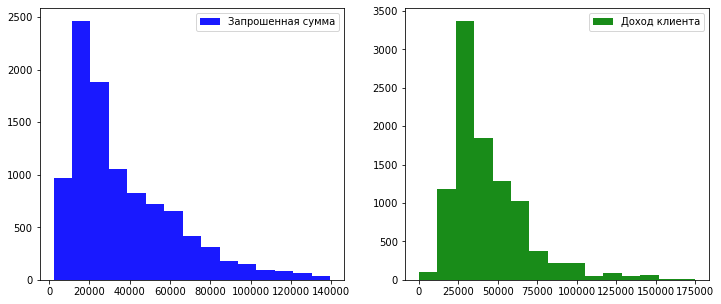

In [7]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(df.required_amt[df.required_amt < df.required_amt.quantile(0.99)],
           bins = 15,
           color = 'b',
           alpha = 0.9,
           label = 'Запрошенная сумма')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(df.monthly_income_amt[df.monthly_income_amt < df.monthly_income_amt.quantile(0.99)],
           bins = 15,
           color = 'g',
           alpha = 0.9,
           label = 'Доход клиента')
pylab.legend()

pylab.show()

По точечной оценке видно, что запрошенная сумма меньше ежемесячного дохода, попробуем сделать интервальную оценку, что бы повысить уверенность такого вывода

## z-интервал - на основе Нормального распределения

Допустим, нам откуда-то известно, что среднеквадратическое отклонение $\sigma = 5\cdot10^4$. Построим доверительные интервалы для средних на основе ЦПТ $$\bar{X}_n \pm z_{1-\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}$$

In [8]:
monthly_income_conf_int = _zconfint_generic(df.monthly_income_amt.mean(),
                                            5 * 1e4 / np.sqrt(len(df)),
                                            0.05,
                                            'two-sided')
required_conf_int = _zconfint_generic(df.required_amt.mean(),
                                      5 * 1e4 / np.sqrt(len(df)),
                                      0.05,
                                      'two-sided')

print(f'monthly_income_amt 95% confidence interval: [{monthly_income_conf_int[0]:,.2f} - {monthly_income_conf_int[1]:,.2f}]')
print(f'required_amt 95% confidence interval: [{required_conf_int[0]:,.2f} - {required_conf_int[1]:,.2f}]')

monthly_income_amt 95% confidence interval: [45,562.76 - 47,522.72]
required_amt 95% confidence interval: [36,826.17 - 38,786.13]


## t-интервал - На основе распределения Стьюдента

### О распределении Стьюдента

**Шаг № 1**

Пусть $X \sim F(x)$, где $F(x)$ - некоторое распределение, о котором известно:
$$E(x) = \mu$$
$$D(x) = \sigma^2$$

В нашем распоряжении есть выборка объемом $n$ $$X^n = (X_1, . . . , X_n)$$

Вспомним Центральную Предельную Теорему
$$\bar{X}_n\approx\sim N \biggl ( E(x), \frac{D(x)}{n} \biggr)$$

И рассмотрим следующую случайную величину $$Y = \frac{\bar{X}_n -\mu}{\sigma}{\sqrt{n}}$$

Видно, что она имеет стандартное нормальное распределение
$$Y \sim N (0, 1)$$

На основе квантилей этого распределения и строится z-интервал для оценки $\mu$. Стоит обратить внимание, что здесь используется дисперсия $\sigma$, которую по выборке разумеется никак не понять.

**Шаг № 2**

Давайте тогда рассмотрим другую случайную величину $T$, заменив неизвестную истинную дисперсию $\sigma$ её несмещенной выборочной оценкой $S$   $$T = \frac{\bar{X}_n -\mu}{S}{\sqrt{n}}$$

Какое распределение имеет такая случайная величина?

**Шаг № 3**

Рассмотрим $X$ такую, что: $$X \sim N(\mu, \sigma^2)$$
Вспомним во-первых, что: $$S^2 = \frac{1}{n - 1}\sum_{i = 1}^n (X_i - \bar{X}_n)^2$$

А также: $$\frac{X_i - \bar{X}_n}{\sigma} \sim N(0, 1)$$

Тогда: $$\frac{(n - 1)\cdot S^2}{\sigma^2} = \sum_{i = 1}^n \frac{(X_i - \bar{X}_n)^2}{\sigma^2} \sim \sum_{i = 1}^n N^2(0, 1)$$

**Шаг № 4**

Вспомним, что по определению, если ${z_{1},\ldots ,z_{k}}$ - совместно независимые стандартные нормальные случайные величины: ${z_{i}\sim N(0,1)}$. Тогда сумма их квадратов распределена по хи-квадрат с $k$ степенями свободы: $$\sum_{i = 1}^k z_i^2 \sim \chi^2(k)$$

Стоит заметить, что в сумму $$\sum_{i = 1}^n \frac{(X_i - \bar{X}_n)^2}{\sigma^2}$$ входит только лишь $n - 1$ независимая случайная величиа, так как ввиду оценки матожидания по выборке, можно выразить одну из этих случайных величин через совокупность остальных. Поэтому $$\frac{(n - 1)\cdot S^2}{\sigma^2} \sim \chi^2(n - 1)$$

**Шаг № 5**

Теперь мы готовы угадать распределение для $T$
$$T = \frac{\bar{X}_n -\mu}{S}{\sqrt{n}} = \frac{\frac{\bar{X}_n -\mu}{\sigma}{\sqrt{n}}}{\frac{S}{\sigma}} \sim \frac{N(0, 1)}{\sqrt{\frac{\chi^2(n - 1)}{n - 1}}}$$

По определению, такая случайная величина имеет распределение Стьюдента c $n - 1$ степенью свободы $St(n - 1)$ на основе кванителей которого строится t-интервал. $t_{1-\frac{\alpha}{2}}$ при построении t-интервала это именно квантиль распределения Стьюдента, а не стандартного нормального, как при построении z-интервала.

**Важное замечание**: внимательный читатель заметил, что вывод был произведен для нормально распределенной случайной величины, правда в том, что для непрерывных величин, не являющихся нормальными, как в нашем примере, данный вывод также справдлив с какой-то степенью точности. Теоритеческое обсуждение данного факта выходит за рамки нашего курса. Предлагаю при наличии интереса к этому вопросу поковыряться в интернете самостоятельно. Отсылки к проблемам нормальности исходных данных вы ещё встретите в курсе (да что там в курсе - в жизни!) в дальнейшем, в частности в лекциях про t-тесты Стьюдента. Будьте внимательны, и пользуйтесь параметрическими z- и t-интервалами для данных, в которых хоть как-то угадывается нормальное распределение, как в нашем случае.





### Применительно к построению интервалов

Вместо гипотетической $\sigma$, которую мы выдумали, используем выборочные дисперсии, и построим доверительные интервалы вида $$\bar{X}_n \pm t_{1-\frac{\alpha}{2}} \frac{S}{\sqrt{n}}$$

In [7]:
monthly_income_conf_int = _tconfint_generic( df.monthly_income_amt.mean(),
                                            df.monthly_income_amt.std(ddof=1)/np.sqrt(len(df)),
                                            len(df) - 1,
                                            0.05,
                                            'two-sided')
required_conf_int = _tconfint_generic(df.required_amt.mean(),
                                      df.required_amt.std(ddof=1)/np.sqrt(len(df)),
                                      len(df) - 1,
                                      0.05,
                                      'two-sided')

print(f'monthly_income_amt 99% confidence interval: [{monthly_income_conf_int[0]:,.2f} - {monthly_income_conf_int[1]:,.2f}]')
print(f'required_amt 99% confidence interval: [{required_conf_int[0]:,.2f} - {required_conf_int[1]:,.2f}]')

monthly_income_amt 99% confidence interval: [45,832.75 - 47,252.73]
required_amt 99% confidence interval: [37,228.29 - 38,384.01]


## Интервальная оценка для парных выборок

Визуализируем график разности

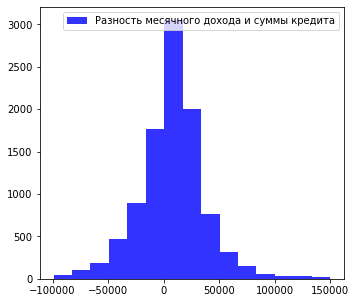

In [8]:
min_diff = np.percentile(df[df.required_amt.notnull()].monthly_income_amt - df[df.required_amt.notnull()].required_amt, 0.5)
max_diff = np.percentile(df[df.required_amt.notnull()].monthly_income_amt - df[df.required_amt.notnull()].required_amt, 99.5)
sample = df.monthly_income_amt.values - df.required_amt.values
sample = sample[(min_diff < sample) & (sample < max_diff)]

pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(sample,
           bins = 15,
           color = 'b',
           alpha = 0.8,
           label = 'Разность месячного дохода и суммы кредита')
pylab.legend()
pylab.show()

*Небольшая ремарка*

У вас может появиться вопрос, а почему такое симметричное распределение? Мы же показали, что интервалы не пересекаются?

In [9]:
print(f'5% перцентиль разности = {np.percentile(sample, 5):,.2f}')

5% перцентиль разности = -41,442.95


Построим предсказательный интервал для той же разности, воспользовавшись похожестью распределения на нормальное, строим t-интервал

In [10]:
diff_pred_int = _zconfint_generic(sample.mean(),
                                  sample.std(ddof=1),
                                  0.05,
                                  'two-sided')

print(f'amount difference 95% predictive interval: [{diff_pred_int[0]:,.2f} - {diff_pred_int[1]:,.2f}]')

amount difference 95% predictive interval: [-50,402.44 - 66,575.07]


Как видно - лежит он по обе стороны от нуля

*Конец ремарки*

Теперь построим доверительный интервал для случайной величины $D$ - средней разности ежемесячного дохода и запрошенной суммы кредита с помощью t-статистики $$\bar{D}_n \pm t_{1-\frac{\alpha}{2}} \frac{S_d}{\sqrt{n}}$$

In [11]:
diff_conf_int = _tconfint_generic(sample.mean(),
                                  sample.std(ddof=1)/np.sqrt(len(sample)),
                                  len(df) - 1,
                                  0.01,
                                  'two-sided')

print(f'required_amt 99% confidence interval: [{diff_conf_int[0]:,.2f} - {diff_conf_int[1]:,.2f}]')

required_amt 99% confidence interval: [7,313.55 - 8,859.09]


Лежит полностью правее нуля -> статистически значимый результат на уровне значимости 1%

# Интервальная оценка для доли

Теперь давайте поработаем с бернуллиевской случайной величиной, построим доверительный интервал для доли заемщиков с высшим образованием 

## z-интервал: На основе нормального распределения

$$\hat{p}\pm z_{1-\frac{\alpha}{2}} \sqrt{\frac{\hat{p}\left(1-\hat{p}\right)}{n}}$$

In [12]:
normal_education_conf_int = proportion_confint(df.has_high_education_flg.sum(),
                                               len(df.has_high_education_flg),
                                               alpha = 0.01,
                                               method = 'normal')

In [13]:
print(f'has_high_education 99% confidence interval: [{normal_education_conf_int[0]:.3f} - {normal_education_conf_int[1]:.3f}]')

has_high_education 99% confidence interval: [0.340 - 0.364]


## Доверительный интервал Уилсона

Для долей существует более качетсвенный метод построения доверительных интервалов - метод Уилсона.

Он позволяет получать качественные оценки для долей близких к нулю или единице. Формула расчета такая:

$$\frac1{ 1 + \frac{z^2}{n} } \left( \hat{p} + \frac{z^2}{2n} \pm z \sqrt{ \frac{ \hat{p}\left(1-\hat{p}\right)}{n} + \frac{
z^2}{4n^2} } \right), \;\; z \equiv z_{1-\frac{\alpha}{2}}$$ 

In [14]:
wilson_education_conf_int = proportion_confint(df.has_high_education_flg.sum(),
                                               len(df.has_high_education_flg),
                                               alpha = 0.01,
                                               method = 'wilson')

In [15]:
print(f'has_high_education 99% confidence interval: [{wilson_education_conf_int[0]:.3f} - {wilson_education_conf_int[1]:.3f}]')

has_high_education 99% confidence interval: [0.340 - 0.364]


## Доверительный интервал для разности долей (не связные выборки)

Давайте сравним доли клиентов с высшим образованием среди заявок на рассрочки и кредиты

In [16]:
good_client_education_conf_int = proportion_confint(df[df.installment_flg == 1].has_high_education_flg.sum(),
                                                    len(df[df.installment_flg == 1].has_high_education_flg),
                                                    alpha = 0.01,
                                                    method = 'wilson')

print(f'installment client has_high_education 99% confidence interval: [{good_client_education_conf_int[0]:.3f} - {good_client_education_conf_int[1]:.3f}]')

installment client has_high_education 99% confidence interval: [0.347 - 0.379]


In [17]:
bad_client_education_conf_int = proportion_confint(df[df.installment_flg == 0].has_high_education_flg.sum(),
                                                    len(df[df.installment_flg == 0].has_high_education_flg),
                                                    alpha = 0.01,
                                                    method = 'wilson')

print(f'credit client has_high_education 99% confidence interval: [{bad_client_education_conf_int[0]:.3f} - {bad_client_education_conf_int[1]:.3f}]')

credit client has_high_education 99% confidence interval: [0.314 - 0.354]


Надо как-то уточнять оценки, интервалы пересекаются ((

Построим доверительный интервал для разности долей

$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

In [18]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.01):
    '''Считает доверительный интервал для разности долей в независимых выборках'''
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    sigma = np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    left_boundary = (p1 - p2) - z * sigma
    right_boundary = (p1 - p2) + z * sigma
    return (left_boundary, right_boundary)

In [19]:
proportions_confint_diff_ind(df[df.installment_flg == 1].has_high_education_flg,
                             df[df.installment_flg == 0].has_high_education_flg)

(0.003690580769893991, 0.054273574976633474)

Решили проблему! Как это понять из доверительного интервала?

## Доверительный интервал для разности долей (связные выборки)

Рассмотрим надуманный, но хороший для иллюстрации пример:
Надо оценить разность вероятности одобрения и факта, что клиент не моложе 39 лет

In [20]:
respect_client_conf_int = proportion_confint(df[df.installment_flg == 1].age.apply(lambda x: 1 if x >= 39 else 0).sum(),
                                         len(df[df.installment_flg == 1]),
                                         alpha = 0.01,
                                         method = 'wilson')

print(f'respect client 99% confidence interval: [{respect_client_conf_int[0]:.3f} - {respect_client_conf_int[1]:.3f}]')

respect client 99% confidence interval: [0.225 - 0.253]


In [21]:
agr_client_conf_int = proportion_confint(df[df.installment_flg == 1].approved_flg.sum(),
                                         len(df[df.installment_flg == 1]),
                                         alpha = 0.01,
                                         method = 'wilson')

print(f'approved client 99% confidence interval: [{agr_client_conf_int[0]:.3f} - {agr_client_conf_int[1]:.3f}]')

approved client 99% confidence interval: [0.247 - 0.275]


Интервалы пересекаются, не получается сделать однозначного вывода 

Посчитать разность долей как в прошлом примере не получится - почему?

Вспомним, что выборки связные

Ранее были разные заявки - на рассрочку и на кредит -> они не пересекались

Теперь мы смотрим на одни и те же заявки, но на разные показатели (доля одобрений и возраста не меньше 39 лет)

Составим матрицу:

  | $p_1$ \ $p_2$ | 0| 1 | $\sum$
  ------------- | -------------|-------------|--------------
  0  | $a_{00}$ | $a_{01}$ | $a_{00}$+$a_{01}$
  1  | $a_{10}$ | $a_{11}$ | $a_{10}$+$a_{11}$
  $\sum$ | $a_{00}$+$a_{10}$| $a_{01}$+$a_{11}$ | n  


$$ \hat{p}_1 = \frac{a_{10}+a_{11}}{n}$$

$$ \hat{p}_2 = \frac{a_{01}+a_{11}}{n}$$

$$ \hat{p}_1 - \hat{p}_2 = \frac{a_{10}-a_{01}}{n}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\;  \frac{a_{10}-a_{01}}{n} \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{a_{10}+a_{01}}{n^2} - \frac{(a_{10}-a_{01})^2}{n^3}}$$

In [22]:
def proportions_confint_diff_rel(sample1, sample2, alpha = 0.01):
    '''Считает доверительный интервал для разности долей в связных выборках'''
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    n = len(sample1)
    a_10 = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in zip(sample1, sample2)])
    a_01 = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in zip(sample1, sample2)])
    sigma = np.sqrt(float((a_10 + a_01)) / n ** 2 - float((a_10 - a_01) ** 2) / n ** 3)
    left_boundary = float(a_10 - a_01) / n  - z * sigma
    right_boundary = float(a_10 - a_01) / n  + z * sigma
    return (left_boundary, right_boundary)

In [23]:
proportions_confint_diff_rel(df[df.installment_flg == 1].approved_flg,
                             df[df.installment_flg == 1].age.apply(lambda x: 1 if x >= 39 else 0))

(0.003831804602544883, 0.03961867463068195)

# Доверительные интервалы с Bootstrap

Посмотрим на распределение возраста заявителя в разрезе решения банка

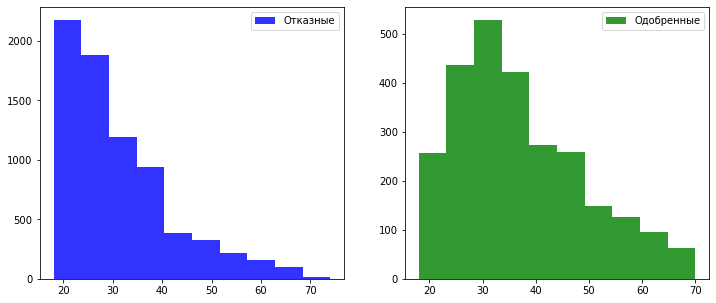

In [24]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(df[df.approved_flg == 0].age,
          #  bins = 15,
           color = 'b',
           alpha = 0.8,
           label = 'Отказные')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(df[df.approved_flg == 1].age,
          #  bins = 15,
           color = 'g',
           alpha = 0.8,
           label = 'Одобренные')
pylab.legend()

pylab.show()

Распределения очень сильно скошены, при этом величина (возраст) не является даже непрерывной, поэтому давайте вместо среднего оценим различия по медиане

In [25]:
print(f'Медианный возраст отказных клиентов = {df[df.approved_flg == 0].age.median()}')
print(f'Медианный возраст одобренных клиентов = {df[df.approved_flg == 1].age.median()}')

Медианный возраст отказных клиентов = 28.0
Медианный возраст одобренных клиентов = 35.0


Идеальный способ оценки какой-либо статистики - это извлечение выборок из генеральной совокупности и оценка необходимой статистики по этим выборкам, проблема в неизвестности распределения генеральной совокупности.

Лучшая оценка этого распределения — имеющаяся выборка. Давайте извлекать из нее с возвращением подвыборки равного объема.

Далее на каждой из подвыборок можно вычислить нужную статистику, и таким образом оценивать эмпирическую функцию распределения.

То есть в отличии от параметрических методов при помощи бутстрепа мы будем оценивать не теоретическую, а именно эмпирическую функцию распределения.

In [26]:
def get_bootstrap_samples(data, n_samples):
    '''Генерирует заданное кол-во (n_samples) выборок, равных по размеру исходной выборке'''
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [27]:
def get_stat_intervals(stat, alpha):
    '''Для заданной выборки возвращает двусторонний доверительный интервал [aplpha/2, 1 - alpha/2]'''
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

Оцениваем интервально

In [33]:
np.random.seed(42)

approved_median_scores = list(map(np.median, get_bootstrap_samples(df[df.approved_flg == 1].age.values, 1000)))
rejected_median_scores = list(map(np.median, get_bootstrap_samples(df[df.approved_flg == 0].age.values, 1000)))

print('approved client 99% confidence interval:',  get_stat_intervals(approved_median_scores, 0.01))
print('rejected client 99% confidence interval:',  get_stat_intervals(rejected_median_scores, 0.01))

approved client 99% confidence interval: [34. 35.]
rejected client 99% confidence interval: [28. 29.]


Модно даже "спарить" выборки

In [29]:
diff_median_scores = list(map(lambda x: x[0] - x[1], zip(approved_median_scores, rejected_median_scores)))
print(f'Средняя разница в возрасте: {sum(diff_median_scores) / len(diff_median_scores) :.2f} лет')

Средняя разница в возрасте: 6.58 лет


In [30]:
print('99% confidence interval for the difference between medians',  get_stat_intervals(diff_median_scores, 0.01))

99% confidence interval for the difference between medians [5. 7.]


# Домашнее задание

### На основе того же набора данных требуется
 
1. Построить предсказательные интервалы для ежемесячного дохода и запрошенной суммы (в предположении логнормальности - логарифм этих переменных имеет нормальное распределение)
2. Определить для каждого признака, разделяет ли он риски. Т.е. надо строить доверительные интервалы для **approved_flg** по каждому признаку. *Подсказка:* для бинарных признаков можно строить интервалы на разность долей, для вещественных признаков - используйте разбивки на бакеты (группы равного размера) и сравнивайте полученные интервалы между этими группами. Попробуйте визуализировать результаты (для вещественных признаков).
 